# Análise de técnicas de agrupamento de dados para notícias de futebol

## Carregando os dados

Os dados serão importados da base de dados `ge-soccer-clubs-news`, disponível em [link](https://www.kaggle.com/datasets/lgmoneda/ge-soccer-clubs-news).

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('./ge_news_all_2022.csv', sep=',', encoding='utf8')

labels = df.club
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]

print(f"{len(df.text)} documentos - {true_k} categorias")

32042 documentos - 21 categorias


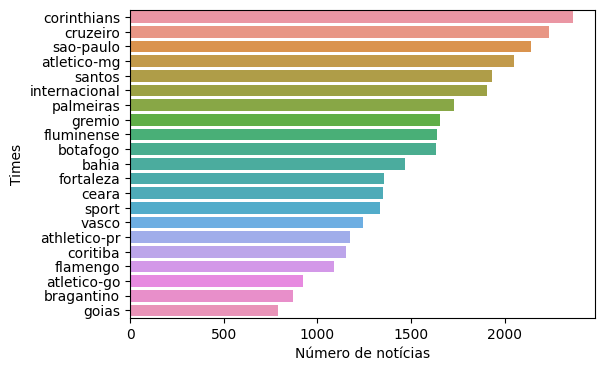

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

news_per_club = df['club'].value_counts()-

plt.figure(figsize=(6,4))
sns.barplot(x= news_per_club.values, y=news_per_club.index)
plt.xlabel('Número de notícias')
plt.ylabel('Times')
plt.show()

## Carregando os pacotes necessários

In [2]:
import nltk
import os

nltk.download('stopwords', download_dir=download_dir)
nltk.download('punkt', download_dir=download_dir)
nltk.download('rslp', download_dir=download_dir)
nltk.download('corpus')

Pacotes disponíveis na  biblioteca [SpaCy](https://spacy.io/)

In [ ]:
!python -m spacy download pt_core_news_lg

## Extração de recursos usando TF-IDF

Representação no espaço vetorial usando a classe [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn-feature-extraction-text-tfidfvectorizer) que implementa o método TF-IDF.

In [4]:
import spacy

nlp = spacy.load('pt_core_news_lg')

In [5]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

stop_words = set(stopwords.words('portuguese'))

tokenizer = RegexpTokenizer(r'(?u)\b\w{2,}\b')

In [6]:
from spacy.tokens import Doc
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import RSLPStemmer
import re

def stem_tokens(tokens):
  stemmer = RSLPStemmer()
  return [stemmer.stem(token) for token in tokens]

def lemmatize_tokens(tokens):
  doc = Doc(nlp.vocab, words=tokens)
  doc = nlp(doc)
  return [token.lemma_ for token in doc]

def filter_existing_tokens(tokens):
  existing_tokens = [token for token in tokens if not nlp.vocab[token.lower()].is_oov]
  return existing_tokens

def remove_stopwords(tokens):
  return [token for token in tokens if token not in stop_words]

def extract_tokens(document):
  tokens = tokenizer.tokenize(document)
  tokens = [token for token in tokens if not re.match(r'\b\d{1,2}h(?:\d{1,2})?\b', token)] # Remove padrão de hora
  tokens = [token for token in tokens if not re.match(r'\b\d+x\d+\b', token)] # Remove padrão de placar de jogo
  tokens = [token for token in tokens if not re.match(r'\b\d+a\b', token)] # Remove padrão de número + a
  tokens = [token for token in tokens if not re.match(r'\b\d+as\b', token)] # Remove padrão de número + as
  tokens = [token for token in tokens if not re.match(r'^\d+$', token)] # Remove padrão de números inteiros
  tokens = [token for token in tokens if not re.match(r'\b\d+(?:ª|º)\b', token)] # Remove padrão de número ordinal
  tokens = [token for token in tokens if not re.match(r'.*[a-zA-Z].*\d|\d.*[a-zA-Z].*', token)] # Remove padrão de combinação entre letras e números
  tokens = [token for token in tokens if not token in ['ge', 'xg']] # Remove tokens específicos
  return tokens

def tokenize(document):
  tokens = extract_tokens(document)
  tokens = remove_stopwords(tokens)
  tokens = filter_existing_tokens(tokens)
  # tokens = stem_tokens(tokens) #optional
  # tokens = lemmatize_tokens(tokens) #optional
  return tokens

vectorizer = TfidfVectorizer(
  tokenizer=tokenize,
  token_pattern=None,
)

t0 = time()

X_tfidf = vectorizer.fit_transform(df.text.values)
feature_names = vectorizer.get_feature_names_out()

print(f"Vetorização finalizada em {time() - t0:.3f} s")
print(f"Número de amostras: {X_tfidf.shape[0]}, número de recursos: {X_tfidf.shape[1]}")

Vetorização finalizada em 76.976 s
Número de amostras: 32042, número de recursos: 45035


In [156]:
import pickle

token_lists = []

for document in df.text.values:
    tokens = tokenize(document)
    token_lists.append(tokens)

with open('tokens_list.txt', 'w', encoding='utf-8') as f:
    for token_list in token_lists:
        f.write(' '.join(token_list) + '\n')

## Redução de dimensionalidade usando LSA

Redução de dimensionalidade usando a técnica LSA, que utiliza o método de decomposição [TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

In [7]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import numpy as np

t0 = time()

lsa = make_pipeline(TruncatedSVD(n_components=32, random_state=42, n_iter=20), Normalizer(copy=False))
X_lsa = lsa.fit_transform(X_tfidf)
[svd, _] = lsa

explained_variance = svd.explained_variance_ratio_.sum()

print(f"Decomposição LSA finalizada em {time() - t0:.3f} s")
print(f"Variância da etapa SVD: {explained_variance * 100:.1f}%")

Decomposição LSA finalizada em 4.622 s
Variância da etapa SVD: 19.2%


### Importância relativa de cada componente

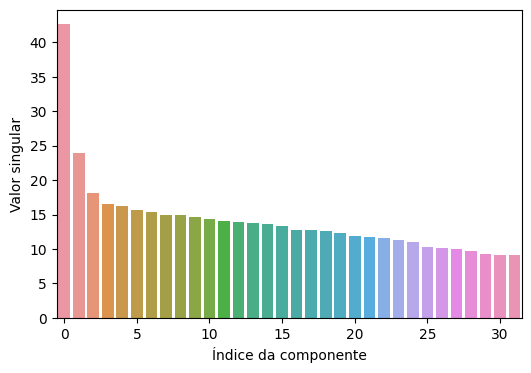

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

tfidf_lsa_data = X_lsa
Sigma = svd.singular_values_
V_T = svd.components_.T

plt.figure(figsize=(6, 4))
x_positions = list(range(len(Sigma)))
ax = sns.barplot(x=x_positions, y=Sigma)
x_positions_to_label = x_positions[::5]
ax.set_xticks(x_positions_to_label)
plt.xticks(rotation=0)
plt.xlabel('Índice da componente')
plt.ylabel('Valor singular')
plt.show()

### Termos mais importantes por tópico

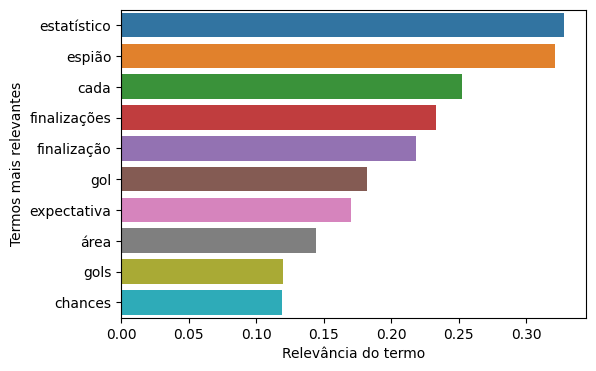

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

tfidf_train_df = pd.DataFrame(X_tfidf.toarray(), 
                        columns=feature_names)

V_T = svd.components_.T
lsa_term_topic = V_T
eda_train = tfidf_train_df

term_topic_matrix = pd.DataFrame(data=lsa_term_topic,
                                 index = eda_train.columns, 
                                 columns = [f'Latent_concept_{r}' for r in range(0,V_T.shape[1])])

data = term_topic_matrix[f'Latent_concept_1']
data = data.sort_values(ascending=False)
top_10 = data[:10]
plt.figure(figsize=(6, 4))
sns.barplot(x= top_10.values, y=top_10.index)
plt.xlabel('Relevância do termo')
plt.ylabel('Termos mais relevantes')
plt.savefig('Latent_concept_1.svg', format='svg')
plt.show()

### Representação 3D

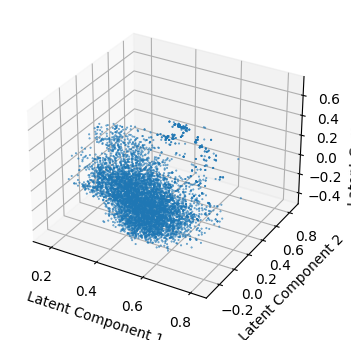

In [10]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

percentage_to_keep = 20
num_points_to_keep = int((percentage_to_keep / 100) * len(X_lsa))
sampled_indices = np.random.choice(len(X_lsa), num_points_to_keep, replace=False)
X_sampled = X_lsa[sampled_indices]

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_sampled[:, 0], X_sampled[:, 1], X_sampled[:, 2], alpha=0.8, s=0.2)
ax.set_xlabel('Latent Component 1')
ax.set_ylabel('Latent Component 2')
ax.set_zlabel('Latent Component 3')
plt.show()

## Utils

In [11]:
from sklearn import metrics

def calculate_metrics(X, true_labels, predicted_labels):
  print('Homogeneity', metrics.homogeneity_score(true_labels, predicted_labels))
  print('Completeness', metrics.completeness_score(true_labels, predicted_labels))
  print('V-measure', metrics.v_measure_score(true_labels, predicted_labels))
  print('Adjusted Rand-Index', metrics.adjusted_rand_score(true_labels, predicted_labels))
  print('Fowlkes-Mallows', metrics.fowlkes_mallows_score(true_labels, predicted_labels))
  print('Normalized Mutual Information', metrics.normalized_mutual_info_score(true_labels, predicted_labels))
  print('Silhouette Coefficient', metrics.silhouette_score(X, predicted_labels))

def calculate_accuracy(df, predicted_labels):
  df['cluster_label'] = predicted_labels
  clusters = df.groupby('cluster_label')
  cluster_category = clusters['club'].agg(lambda x: x.value_counts().index[0])
  cluster_category_map = dict(zip(cluster_category.index, cluster_category.values))
  df['predicted_category'] = df['cluster_label'].map(cluster_category_map)
  success_rate = (df['club'] == df['predicted_category']).mean()
  accuracy = round(success_rate, 2)*100
  return accuracy

## Agrupamento usando K-Means

Agrupamento usando a classe [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

In [12]:
from sklearn.cluster import KMeans

kmeans = KMeans(
  n_clusters=27,
  n_init=10,
  random_state=3
).fit(X_lsa)

labels = kmeans.labels_

df['cluster'] = labels

accuracy = calculate_accuracy(df, labels)

print('Accuracy:', accuracy, '%')

calculate_metrics(X_lsa, df['club'], labels)

Accuracy: 73.0 %
Homogeneity 0.6611896207502517
Completeness 0.6140975713377566
V-measure 0.6367741208655394
Adjusted Rand-Index 0.6165196297373688
Fowlkes-Mallows 0.6380233668115731
Normalized Mutual Information 0.6367741208655394
Silhouette Coefficient 0.3377286226704797


In [ ]:
teste={}

for cat in df['club'].unique():
  print(f"{cat}\n{df[df['club'] == cat]['cluster'].value_counts().head(2)}\n")
  a = df[df['club'] == cat]['cluster'].value_counts().head(2).index
  b = df[df['club'] == cat]['cluster'].value_counts().head(2).values
teste

## Agrupamento usando DBSCAN

Agrupamento usando a classe [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

In [15]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(
  eps=0.4,
  min_samples=36
).fit(X_lsa)

df['cluster'] = dbscan.labels_

## Agrupamento Hierárquico Aglomerativo

Agrupamento usando a classe [AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html).

In [14]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(
  n_clusters = 21,
  linkage = 'ward'
).fit(X_lsa)

df['cluster'] = agg.labels_

accuracy = calculate_accuracy(df, agg.labels_)

print('Accuracy:', accuracy, '%')

calculate_metrics(X_lsa, df['club'], agg.labels_)

Accuracy: 71.0 %
Homogeneity 0.6440553442095397
Completeness 0.6653059052783206
V-measure 0.6545081794596687
Adjusted Rand-Index 0.49490896004922014
Fowlkes-Mallows 0.5279214769503314
Normalized Mutual Information 0.6545081794596685
Silhouette Coefficient 0.2947523392196391


## Agrupamento usando Modelo de Mistura Gaussiana

Agrupamento usando a classe [GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html).

In [16]:
from sklearn.mixture import GaussianMixture

gmm_labels = GaussianMixture(
    n_components=21,
    covariance_type='tied',
    random_state=11,
).fit_predict(X_lsa)

df['cluster'] = gmm_labels

accuracy = calculate_accuracy(df, gmm_labels)

print('Accuracy:', accuracy, '%')

calculate_metrics(X_lsa, df['club'], gmm_labels)

Accuracy: 74.0 %
Homogeneity 0.6521159117920562
Completeness 0.6630025958284117
V-measure 0.6575141932743884
Adjusted Rand-Index 0.568930075028848
Fowlkes-Mallows 0.5929912464989283
Normalized Mutual Information 0.6575141932743885
Silhouette Coefficient 0.30201415457749886


### Referências:

https://towardsdatascience.com/latent-semantic-analysis-intuition-math-implementation-a194aff870f8

https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

https://medium.com/geekculture/what-text-clustering-can-tell-us-about-text-classification-248ce1d5d1e3